In [1]:
import tribolium_clustering as tc
import pyclesperanto_prototype as cle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import rand_score, v_measure_score, silhouette_score, calinski_harabasz_score

lund_folder = tc.get_folder_path('lund')
lund = tc.processed_dataset(lund_folder)

In [2]:
def embryo_serosa_preprocessing(regprops):
    from sklearn.preprocessing import StandardScaler
    aspectrat = tc.min_maj_ax_to_aspectr(regprops,del_min_maj=False)
    subselection = ['area', 'bbox_area', 'extent', 'feret_diameter_max', 'max_intensity',
                    'mean_intensity', 'min_intensity', 'solidity', 'centroid-0',
                    'centroid-1', 'centroid-2', 'image_stdev',
                    'avg distance of 6 closest points',
                    'stddev distance of 6 closest points', 'touching neighbor count',
                    'aspect_ratio']
    subselected = aspectrat[subselection]
    
    scaler = StandardScaler()
    scaled = scaler.fit_transform(subselected)
    
    return scaled

def embryo_serosa_preprocessing_no_scaling(regprops):
    from sklearn.preprocessing import StandardScaler
    aspectrat = tc.min_maj_ax_to_aspectr(regprops,del_min_maj=False)
    subselection = ['area', 'bbox_area', 'extent', 'feret_diameter_max', 'max_intensity',
                    'mean_intensity', 'min_intensity', 'solidity', 'centroid-0',
                    'centroid-1', 'centroid-2', 'image_stdev',
                    'avg distance of 6 closest points',
                    'stddev distance of 6 closest points', 'touching neighbor count',
                    'aspect_ratio']
    subselected = aspectrat[subselection]
    
    return subselected



processed_complete_props_scaled = embryo_serosa_preprocessing(lund.get_combined_regionprops())
processed_complete_props = embryo_serosa_preprocessing_no_scaling(lund.get_combined_regionprops())


from sklearn.cluster import KMeans

kmeans_clust = KMeans(n_clusters=2,max_iter=10000, init= 'k-means++', random_state=42)
unscaled_predictions = kmeans_clust.fit_predict(processed_complete_props)
scaled_predictions = kmeans_clust.fit_predict(processed_complete_props_scaled)

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


In [3]:
def only_annotated_cells_prediction_list(dataset,timepoint,
                                         prediction_list_timepoint,
                                         annotation_folder,annotation_file_name_prefix,annotation_column_name,
                                         ):
    import pandas as pd
    from pyclesperanto_prototype import statistics_of_background_and_labelled_pixels
    from skimage.io import imread
    
    dictinput = {'prediction':prediction_list_timepoint}
    cluster_prediction_csv = pd.DataFrame(dictinput)
    
    labels = dataset.get_labels(timepoint)
    annotation_img = imread(annotation_folder+ 
                              annotation_file_name_prefix + 
                              't{}.tif'.format(timepoint))
    

    cle_regionp = statistics_of_background_and_labelled_pixels(annotation_img,labels)
    annotated_labels = cle_regionp['max_intensity'][1:].astype('uint8')
    
    annotation_df = pd.DataFrame({annotation_column_name:annotated_labels})
    cluster_pred_and_annotation = pd.concat([cluster_prediction_csv,annotation_df], axis = 1)
    
    only_annotated_subset = cluster_pred_and_annotation[cluster_pred_and_annotation[annotation_column_name]>0]
    return only_annotated_subset


def combined_list_to_timepoint_list(dataset,combined_list):
    cum_indices = dataset.cumulative_label_lengths()

    output = [combined_list[cum_indices[timepoint]:cum_indices[timepoint+1]] 
              for timepoint,nothing in enumerate(dataset.timepoints)]
    
    return output


individual_predictions_scaled = combined_list_to_timepoint_list(lund,scaled_predictions)
individual_predictions_unscaled = combined_list_to_timepoint_list(lund,unscaled_predictions)

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


In [4]:
indices_annotation_lund = np.array(range(0,22,3))

annotated_dfs_scaled = [only_annotated_cells_prediction_list(lund,i,
                        individual_predictions_scaled[i],            
                        lund_folder,'serosa embryo annotation rescaled ','serosa_embryo_labels',
                        ) for i in indices_annotation_lund]
annotated_dfs_unscaled  = [only_annotated_cells_prediction_list(lund,i,
                           individual_predictions_unscaled[i],            
                           lund_folder,'serosa embryo annotation rescaled ','serosa_embryo_labels',
                           ) for i in indices_annotation_lund]

In [5]:
from sklearn.metrics import adjusted_rand_score

rand_scores_unscaled = [adjusted_rand_score(annotated['prediction'],
                                   annotated['serosa_embryo_labels']) 
                        for annotated in annotated_dfs_unscaled]
rand_scores_scaled = [adjusted_rand_score(annotated['prediction'],
                                   annotated['serosa_embryo_labels']) 
                        for annotated in annotated_dfs_scaled]

In [6]:
v_measures_unscaled = [v_measure_score(annotated['prediction'],
                                   annotated['serosa_embryo_labels']) 
                        for annotated in annotated_dfs_unscaled]
v_measures_scaled   = [v_measure_score(annotated['prediction'],
                                   annotated['serosa_embryo_labels']) 
                        for annotated in annotated_dfs_scaled]

(0.0, 210.0)

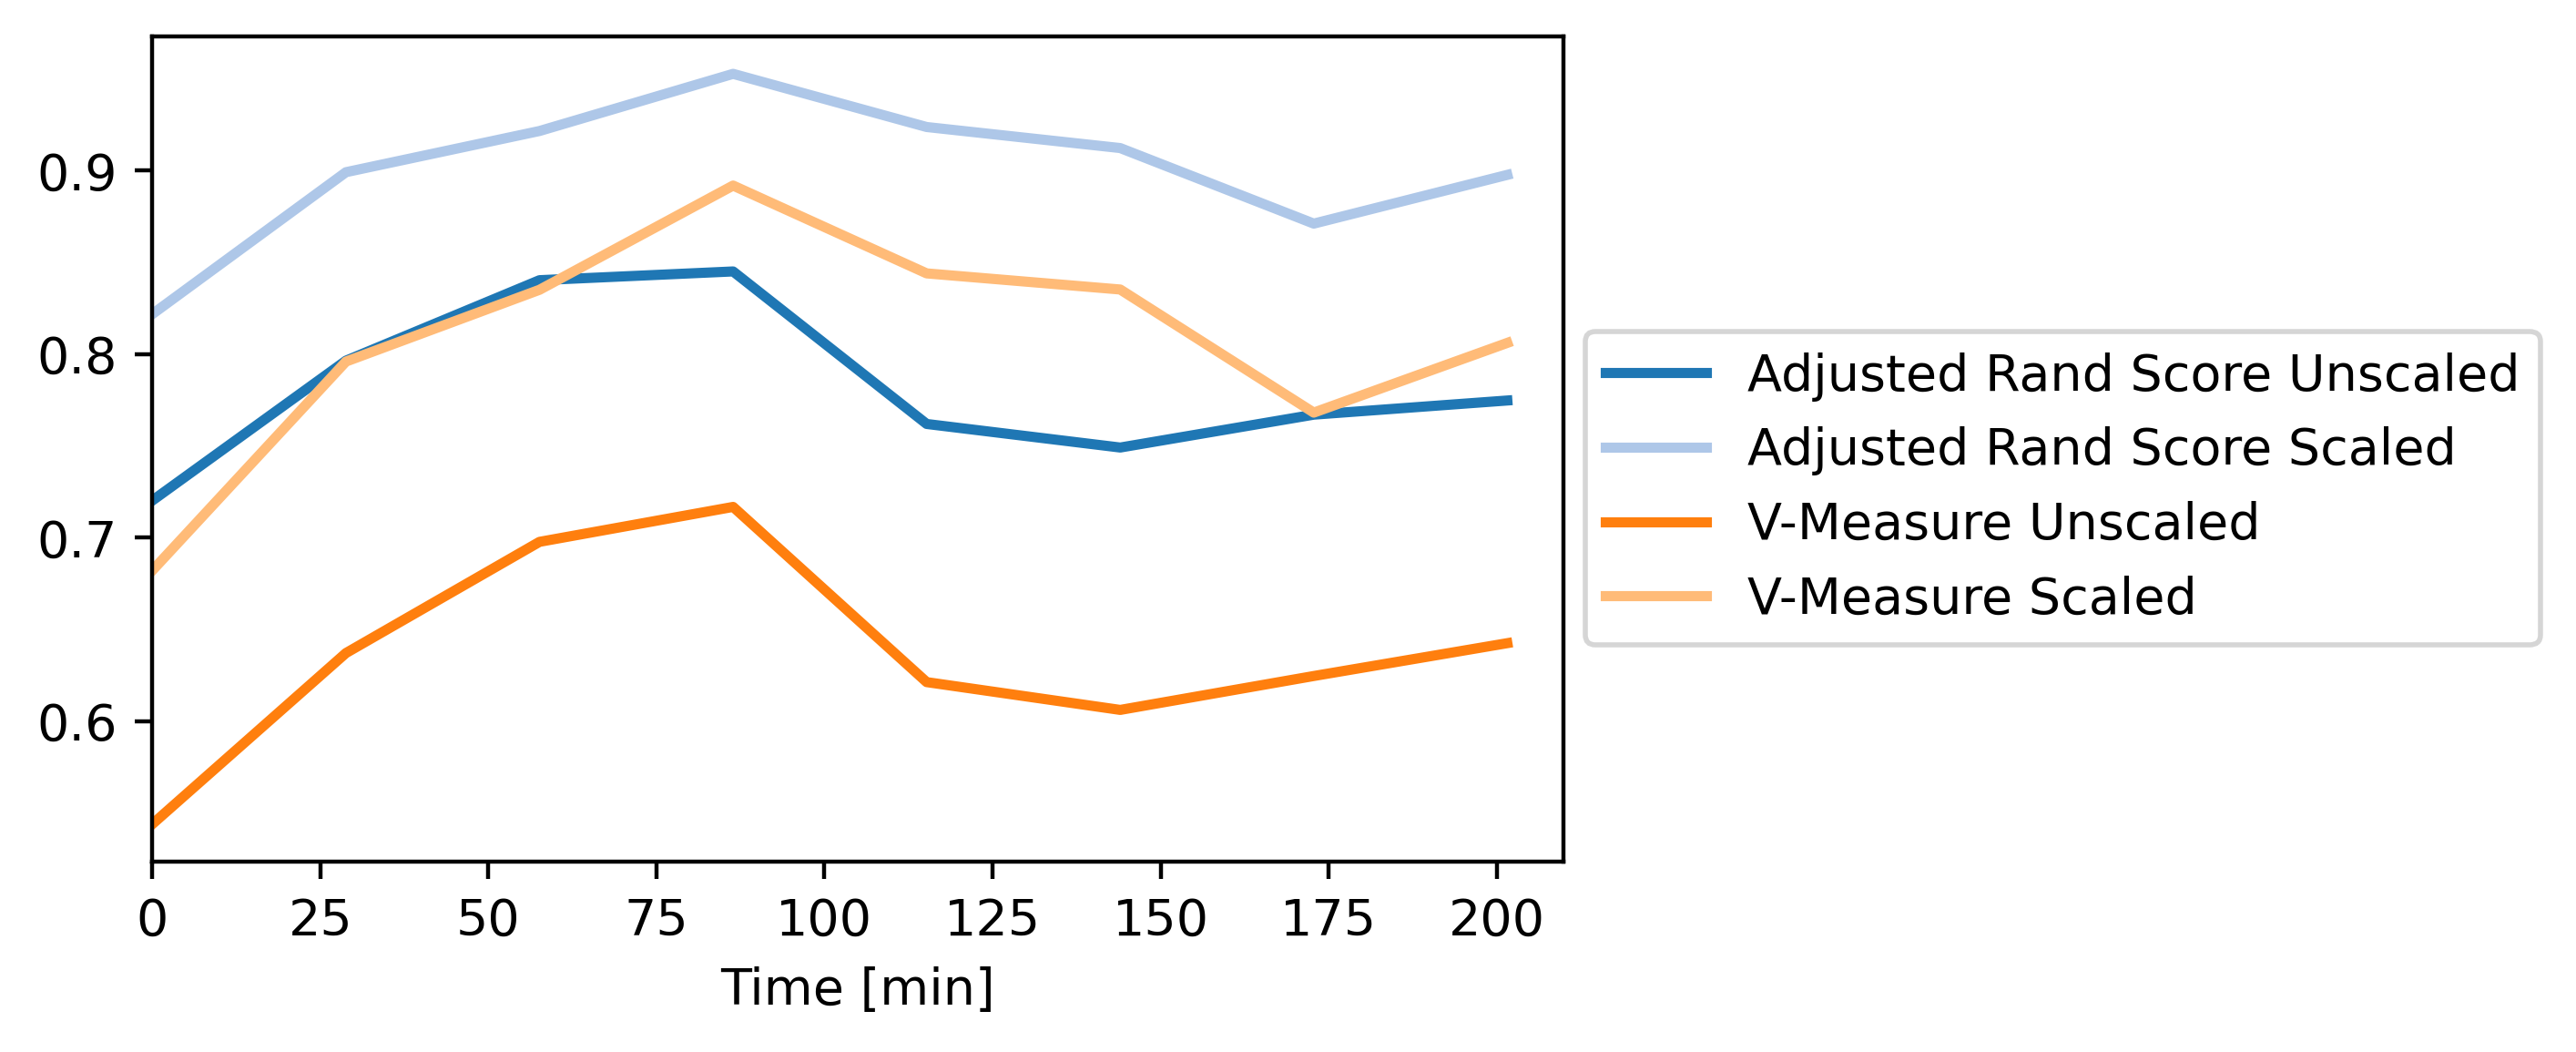

In [9]:
import beetlesafari as bs
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

timeslice_lund = bs.seconds_to_minutes(bs.hours_to_seconds(4/25))
lund_time_in_min = np.array(indices_annotation_lund)* timeslice_lund


from matplotlib import cm
x = np.array(range(6))
cmap_list = cm.get_cmap(plt.get_cmap('tab20'))(x)[np.newaxis, :, :3][0]


lw = 2
big_fs = 10
small_fs = 10
a = 1

fig, ax1 = plt.subplots(1,1,figsize = (5,3))

ax1.plot(lund_time_in_min,rand_scores_unscaled,
         label='Adjusted Rand Score Unscaled',color = cmap_list[0],
         linewidth=lw,alpha =a)
ax1.plot(lund_time_in_min,rand_scores_scaled,
         label='Adjusted Rand Score Scaled',color = cmap_list[1],
         linewidth=lw)
ax1.plot(lund_time_in_min,v_measures_unscaled,
         label='V-Measure Unscaled',color = cmap_list[2],
         linewidth=lw,alpha =a)
ax1.plot(lund_time_in_min,v_measures_scaled,
         label='V-Measure Scaled',color = cmap_list[3],
         linewidth=lw)






handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(1.45,0.3),fontsize =big_fs)
ax1.set_xlabel('Time [min]', fontsize =big_fs)
plt.xticks(fontsize=small_fs)
plt.yticks(fontsize=small_fs)
ax1.set_xlim([0,210])

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\__init__.py:54: UserWarning: 

napari was tested with QT library `>=5.12.3`.
The version installed is 5.9.7. Please report any issues with
this specific QT version at https://github.com/Napari/napari/issues.
  warn(message=warn_message)
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//
No Predictions in Regionprops of D:/Uni/MSTER TUD/Master Thesis/output data/Lund Gastrulation Correct voxel sizes//


C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py:255: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
C:\Users\ryans\anaconda3\envs\mstr_v4\lib\site-packages\napari\layers\base\base.py:629: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data 

---------------------------------------------------------------------------
MemoryError                               Traceback (most recent call last)
~\anaconda3\envs\mstr_v4\lib\site-packages\napari\_qt\qt_event_loop.py in gui_qt(startup_logo=False, gui_exceptions=False, force=False)
    269         splash.close()
    270     try:
--> 271         yield app
        app = <PyQt5.QtWidgets.QApplication object at 0x000001D6A2361040>
    272     except Exception:
    273         notification_manager.receive_error(*sys.exc_info())

<ipython-input-44-e34630994665> in nice_screenshots_of_1_timepoint(dataset=<tribolium_clustering.file_handling._processed_dataset_class.processed_dataset object>, prediction_list=array([0, 0, 0, ..., 1, 1, 1]), timepoint=15, cmap={0: [0.0, 0.0, 0.0, 0], 1: [0.5019607843137255, 0.6941176470588235, 0.8274509803921568, 1], 2: [0.9921568627450981, 0.7058823529411765, 0.3843137254901961, 1], 3: [0.5529411764705883, 0.8274509803921568, 0.7803921568627451, 1], 4: [1.0

MemoryError: Unable to allocate 604. MiB for an array with shape (158334976,) and data type float32

In [ ]:
for i in range(25):
    nice_screenshots_of_1_timepoint(lund,unscaled_predictions, i, 
                                    np_cmap, output_folder_unscaled, 
                                    'K-means ++, scaled, correlation filtered', 
                                    rotation=(0,150,0))